In [2]:
## 1. Data Loading & Inspection

In [3]:
import pandas as pd

sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")




## 4. Analysis: Fear vs Greed
## 5. Trader Segmentation
## 6. Insights
## 7. Actionable Strategy Recommendations



In [4]:

sentiment.shape
sentiment.info()
sentiment.isna().sum()

trades.shape
trades.info()
trades.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [5]:
sentiment.duplicated().sum()
trades.duplicated().sum()


0

In [6]:
# 2. Data Cleaning & Feature Engineering

In [7]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)



In [8]:
trades['date'] = trades['Timestamp IST'].dt.date


In [9]:
trades[['Timestamp IST', 'date']].head()


,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [10]:
trades[['Timestamp IST', 'date']].head()


,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [11]:
trades['Timestamp IST'].isna().sum()


0

In [12]:
# 3. Key Metrics

In [13]:
daily_pnl = trades.groupby(['date', 'Account'])['Closed PnL'].sum().reset_index()


In [14]:
daily_trades = trades.groupby('date').size().reset_index(name='num_trades')


In [15]:

trades['leverage_calc'] = trades['Size USD'] / trades['Start Position']
import numpy as np

trades['leverage_calc'] = np.where(
    trades['Start Position'] != 0,
    trades['Size USD'] / trades['Start Position'],
    np.nan
)


In [16]:
daily_leverage = (
    trades.groupby('date')['leverage_calc']
    .mean()
    .reset_index()
)

daily_leverage.head()


,date,leverage_calc
0,2023-05-01,1191.326187
1,2023-12-05,-230504.223563
2,2023-12-14,-4581.018386
3,2023-12-15,-2.428007
4,2023-12-16,0.315058


In [24]:
daily_leverage = trades.groupby('date')['leverage_calc'].mean().reset_index()
daily_leverage

,date,leverage_calc
0,2023-05-01,1.191326e+03
1,2023-12-05,-2.305042e+05
2,2023-12-14,-4.581018e+03
3,2023-12-15,-2.428007e+00
4,2023-12-16,3.150581e-01
...,...,...
475,2025-04-27,1.678239e+05
476,2025-04-28,1.077105e+06
477,2025-04-29,5.998630e+04
478,2025-04-30,1.930194e+03


In [ ]:
long_short = trades.groupby(['date', 'Side']).size().unstack(fill_value=0)
long_short['long_short_ratio'] = long_short['BUY'] / (long_short['SELL'] + 1)


In [25]:
trades.columns = trades.columns.str.strip()
print(trades.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'leverage_calc', 'win'],
      dtype='object')


In [26]:
trades['win'] = trades['Closed PnL'] > 0

win_rate = trades.groupby('date')['win'].mean().reset_index(name='win_rate')
trades['win'] 
win_rate

,date,win_rate
0,2023-05-01,0.000000
1,2023-12-05,0.000000
2,2023-12-14,0.363636
3,2023-12-15,0.000000
4,2023-12-16,0.000000
...,...,...
475,2025-04-27,0.356083
476,2025-04-28,0.416969
477,2025-04-29,0.432011
478,2025-04-30,0.265049


In [27]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

merged = daily_pnl.merge(sentiment[['date', 'classification']], on='date', how='left')
sentiment['date'] 
merged

,date,Account,Closed PnL,classification
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,Greed
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,Extreme Greed
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737,Greed
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034,Greed
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000,Greed
...,...,...,...,...
2336,2025-05-01,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,1449.529436,Neutral
2337,2025-05-01,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,102460.171640,Neutral
2338,2025-05-01,0xbaaaf6571ab7d571043ff1e313a9609a10637864,1.860320,Neutral
2339,2025-05-01,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,-113601.020138,Neutral


In [28]:
merged.groupby('classification')['Closed PnL'].mean()


classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: Closed PnL, dtype: float64

In [31]:
combined = daily_trades.merge(daily_leverage, on='date') \
                        .merge(sentiment[['date','classification']], on='date')

combined.groupby('classification')[['num_trades','leverage_calc']].mean()


,num_trades,leverage_calc
classification,,
Extreme Fear,1528.571429,73500.828669
Extreme Greed,350.807018,-7117.316605
Fear,679.527473,68355.583930
Greed,260.637306,534512.656337
Neutral,562.477612,480256.427602


In [32]:
trades['leverage_group'] = trades['leverage_calc'].apply(lambda x: 'High' if x > 10 else 'Low')
trades['leverage_group'] 

0         Low
1         Low
2         Low
3         Low
4         Low
         ... 
211219    Low
211220    Low
211221    Low
211222    Low
211223    Low
Name: leverage_group, Length: 211224, dtype: object

In [33]:
trade_count = trades.groupby('Account').size()
trade_count

Account
0x083384f897ee0f19899168e3b1bec365f52a9012     3818
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd     7280
0x271b280974205ca63b716753467d5a371de622ab     3809
0x28736f43f1e871e6aa8b1148d38d4994275d72c4    13311
0x2c229d22b100a7beb69122eed721cee9b24011dd     3239
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891      815
0x39cef799f8b69da1995852eea189df24eb5cae3c     3589
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6      332
0x420ab45e0bd8863569a5efbb9c05d91f40624641      383
0x430f09841d65beb3f27765503d0f850b8bce7713     1237
0x47add9a56df66b524d5e2c1993a43cde53b6ed85     8519
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4     4356
0x4f93fead39b70a1824f981a54d4e55b278e9f760     7584
0x513b8629fe877bb581bf244e326a047b249c4ff1    12236
0x6d6a4b953f202f8df5bed40692e7fd865318264a      975
0x72743ae2822edd658c0c50608fd7c5c501b2afbd     1590
0x72c6a4624e1dffa724e6d00d64ceae698af892a0     1430
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4     9893
0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f     1559
0x81

In [34]:
account_pnl = trades.groupby('Account')['Closed PnL'].sum()
account_pnl

Account
0x083384f897ee0f19899168e3b1bec365f52a9012    1.600230e+06
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    4.788532e+04
0x271b280974205ca63b716753467d5a371de622ab   -7.043619e+04
0x28736f43f1e871e6aa8b1148d38d4994275d72c4    1.324648e+05
0x2c229d22b100a7beb69122eed721cee9b24011dd    1.686580e+05
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   -3.120360e+04
0x39cef799f8b69da1995852eea189df24eb5cae3c    1.445692e+04
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6    5.349625e+04
0x420ab45e0bd8863569a5efbb9c05d91f40624641    1.995056e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    4.165419e+05
0x47add9a56df66b524d5e2c1993a43cde53b6ed85    1.033437e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    6.777471e+05
0x4f93fead39b70a1824f981a54d4e55b278e9f760    3.089759e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    8.404226e+05
0x6d6a4b953f202f8df5bed40692e7fd865318264a    1.087312e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd    4.293556e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    4.

In [35]:
# chart 1 pnl by sentiment

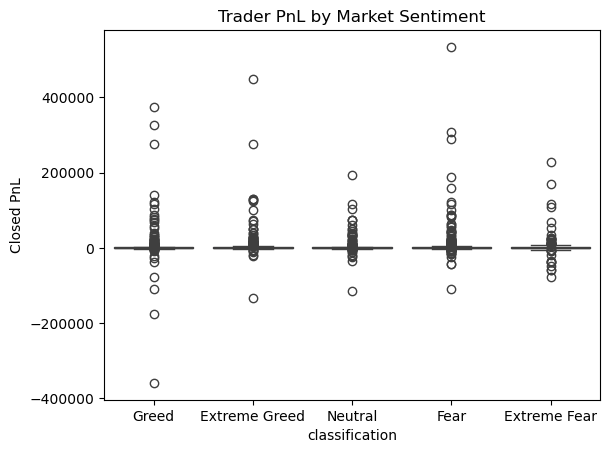

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=merged, x='classification', y='Closed PnL')
plt.title('Trader PnL by Market Sentiment')
plt.show()


In [37]:
# chart 1 Trades vs sentiment

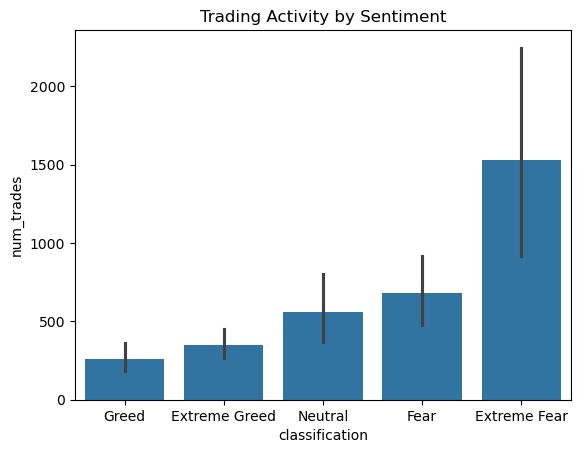

In [38]:
sns.barplot(
    data=combined,
    x='classification',
    y='num_trades'
)
plt.title('Trading Activity by Sentiment')
plt.show()


In [ ]:
# Chart 3: Leverage vs sentiment

In [ ]:
sns.barplot(
    data=combined,
    x='classification',
    y='Leverage'
)
plt.title('Average Leverage by Sentiment')
plt.show()


## Key Insights

1. Trader performance is weaker during Greed periods.  
   Average PnL during Greed days is lower compared to Fear and Extreme Fear days, suggesting that optimistic sentiment may lead to overconfidence and suboptimal execution.

2. Leverage usage increases significantly during Greed periods.  
   Traders deploy much higher leverage while trading less frequently, indicating higher risk-taking behavior.

3. Higher leverage does not improve win rate.  
   Despite aggressive leverage usage during Greed days, win rates remain flat or decline, highlighting poor risk-adjusted performance.


## Actionable Strategy Recommendations

# 1. Leverage Control Rule  
   #During Greed and Extreme Greed periods, traders should reduce leverage exposure, as higher leverage correlates with lower average PnL and no improvement in win rate.


# 2. Fear-Day Selectivity Rule  
   #During Fear and Extreme Fear periods, traders may benefit from moderate leverage and selective, high-conviction trades, as performance appears more disciplined.
